In [1]:
import os
import pandas as pd
import glob
import stagger
import librosa
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
%matplotlib inline
import pathlib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
#wykrycie ścieżki, w której przechowuje pliki i program
working_directory = os.getcwd()
print(working_directory)

C:\Users\akr


In [3]:
pliki_danych = [working_directory + '\wrapped_dataset_226.xlsx',working_directory + '\wrapped_dataset_20s_226.xlsx',working_directory + '\wrapped_dataset_vocal_226.xlsx']

In [4]:
lista_atryburow = ['chroma_stft', 'spectral_centroid', 'spectral_bandwidth',
                   'spectral_rolloff', 'rmse', 'zero_crossing_rate',
                   'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3','mfcc_4','mfcc_5','mfcc_6',
                   'mfcc_7', 'mfcc_8','mfcc_9', 'mfcc_10','mfcc_11', 'mfcc_12',
                   'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19']

In [5]:
#lista przechowujaca tytuly, ktore wykorzystam pozniej przy wykresach
typy_x = ['Wektor X 26 cech', 'Wektor X 2 cech po alg. LDA']

#stworzenie listy klasyfikatorow
klasyfikatory = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
                 SVC(kernel='linear', random_state=0), LogisticRegression(random_state=10),
                 XGBClassifier(n_estimators=152)]

klasyfikatory_names = ['KNN', 'Decision Tree', 'Random Forest', 'SVC', 'Logistic Regression', 'XGBoost']



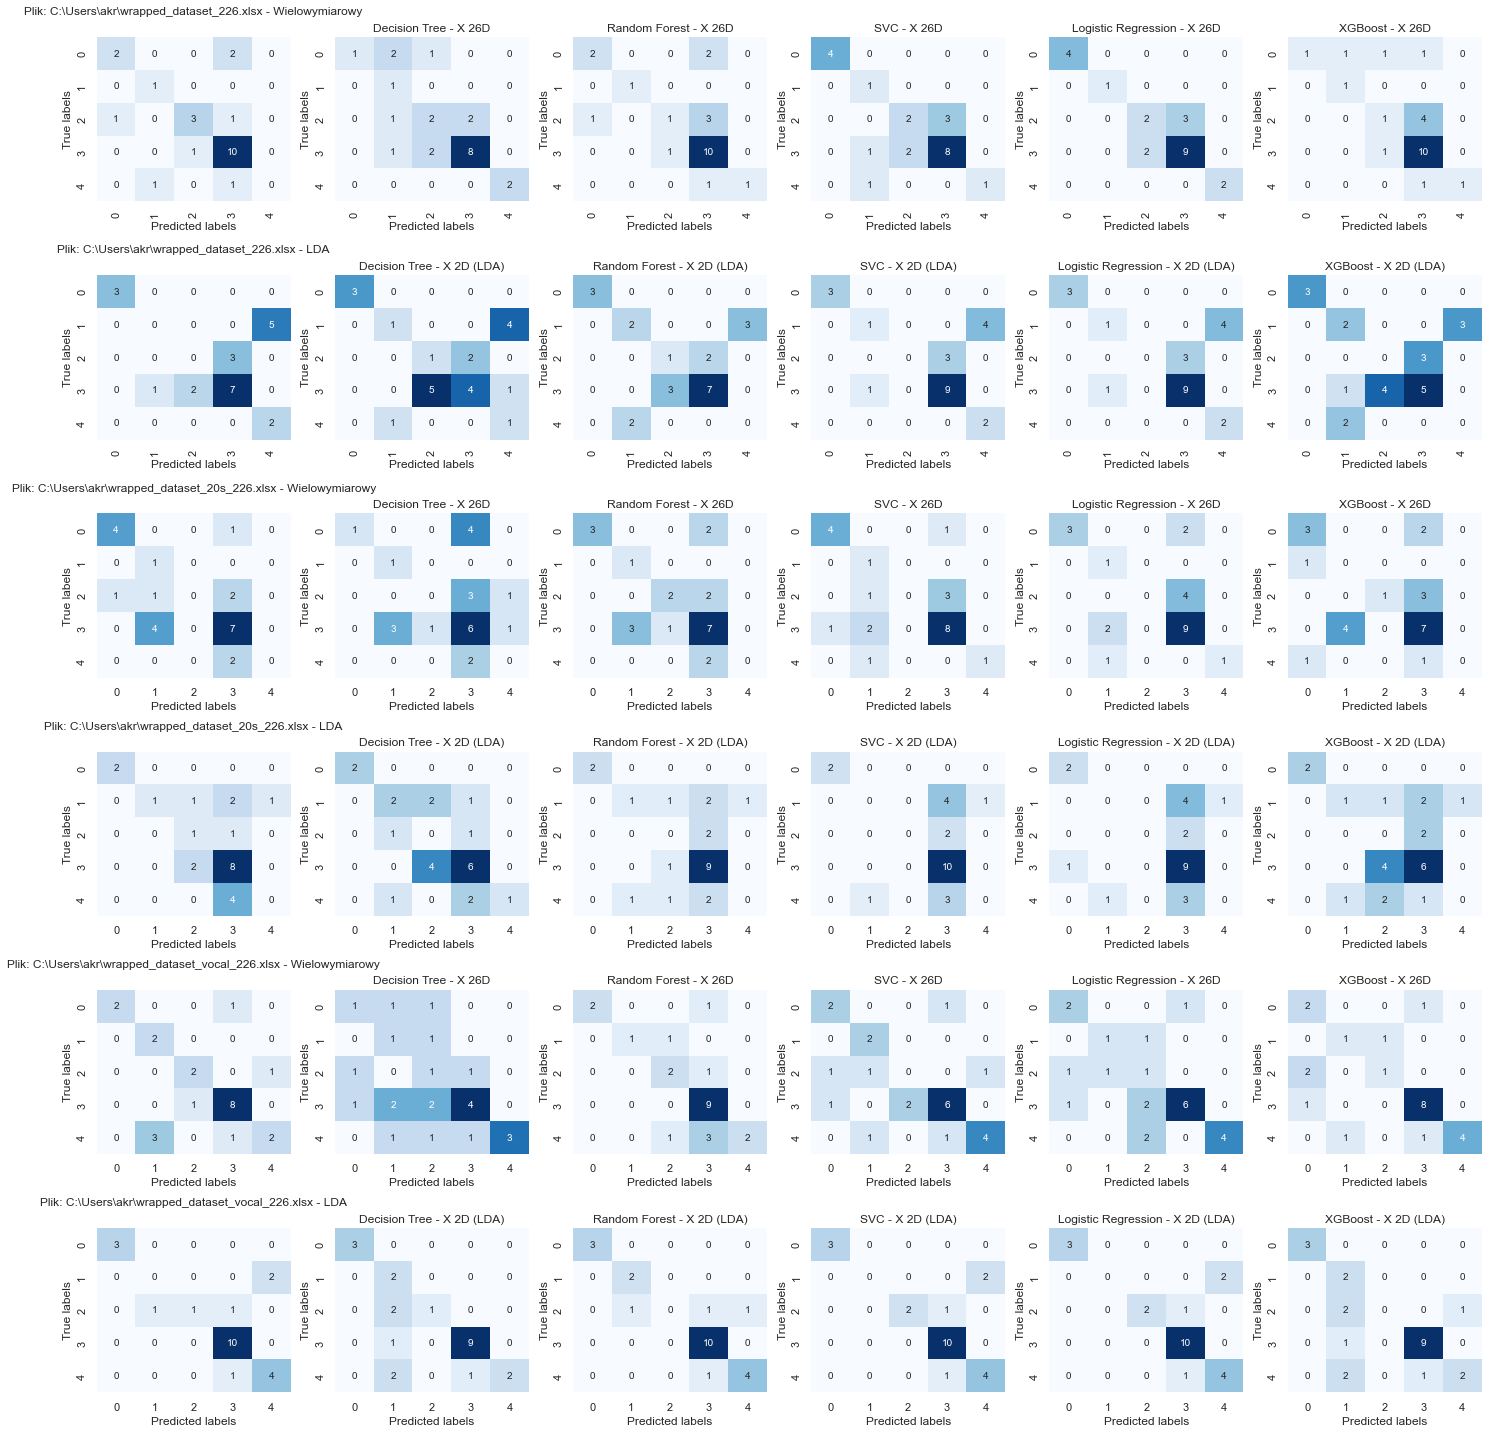

In [6]:


fig, axes = plt.subplots(6, 6, figsize=(20, 20))

klasyfikatory = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
                 SVC(kernel='linear', random_state=0), LogisticRegression(random_state=10),
                 XGBClassifier(n_estimators=152)]

klasyfikatory_names = ['KNN', 'Decision Tree', 'Random Forest', 'SVC', 'Logistic Regression', 'XGBoost']

for i, plik in enumerate(pliki_danych):
    df = pd.read_excel(plik)
    #zmiana etykiet z kolaboracjami na spójne
    df['artist'] = df['artist'].replace(['Coals, Bobkovski'], 'Coals')
    df['artist'] = df['artist'].replace(['Coals, Żabson'], 'Coals')
    df['artist'] = df['artist'].replace(['Coals, felicita'], 'Coals')
    artist_list = df['artist']
    
    #zmapowanie etykiet tekstowych na numeryczne
    encoder = LabelEncoder()
    encoder.fit(artist_list)
    le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    y = encoder.fit_transform(artist_list)
    
    #standaryzacja danych wejsciowych
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(df[lista_atryburow], dtype=float))
    
    #przygotowanie zredukowanego algorytmem LDA do wektora cech X
    lda2d = LDA(n_components=2)
    X_r2 = lda2d.fit(X, y).transform(X)
    df2 = pd.DataFrame(X_r2)
    df2['album'] = y
    lda2d_x = df2[[0, 1]]
    lda2d_y = df2['album']
    
    #podzielenie zbiorów na testowe i treningowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(lda2d_x, y, test_size=0.1)

    X_train_vect = [X_train, X_train_lda]
    X_test_vect = [X_test, X_test_lda]
    y_train_vect = [y_train, y_train_lda]
    y_test_vect = [y_test, y_test_lda]
    target_names = sorted(set(y))

    for j, klasyfikator in enumerate(klasyfikatory):
        klasyfikator.fit(X_train_vect[0], y_train_vect[0])
        y_pred_test = klasyfikator.predict(X_test_vect[0])
        cm = confusion_matrix(y_test_vect[0], y_pred_test, labels=target_names)

        ax = axes[i*2, j]
        sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d", cbar=False)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'{klasyfikatory_names[j]} - X 26D')

        if i == 0:
            ax.xaxis.set_ticklabels(target_names, rotation='vertical')

        klasyfikator.fit(X_train_vect[1], y_train_vect[1])
        y_pred_test = klasyfikator.predict(X_test_vect[1])
        cm = confusion_matrix(y_test_vect[1], y_pred_test, labels=target_names)

        ax = axes[i*2+1, j]
        sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d", cbar=False)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'{klasyfikatory_names[j]} - X 2D (LDA)')

        if i == 0:
            ax.xaxis.set_ticklabels(target_names, rotation='vertical')

    axes[i*2, 0].set_title(f'Plik: {plik} - Wielowymiarowy', fontsize=12, y=1.1)
    axes[i*2+1, 0].set_title(f'Plik: {plik} - LDA', fontsize=12, y=1.1)

plt.tight_layout()
plt.show()


KLASYFIKACJA DLA ZBIORU DANYCH: C:\Users\akr\wrapped_dataset_226.xlsx

Próba dla 26D

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.6573809523809524
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.5345238095238096


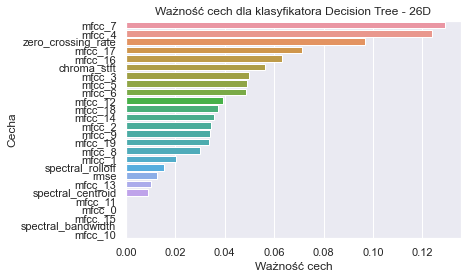

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.6911904761904761
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.7057142857142857
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.7111904761904763
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.7111904761904763


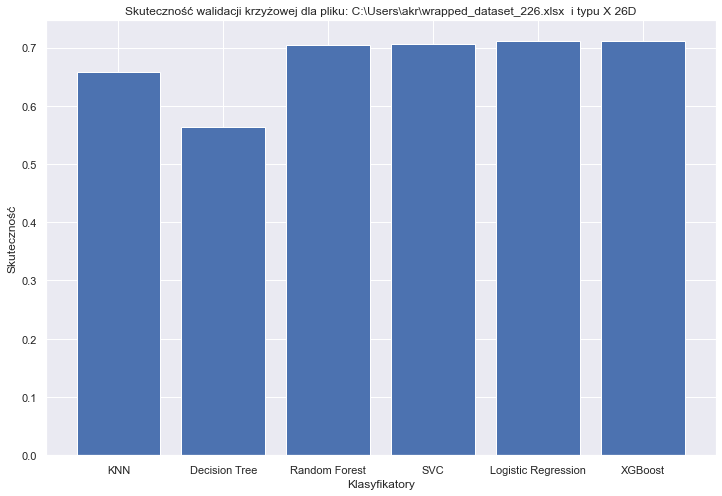

--------------

Próba dla 2D LDA

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.6190476190476191
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.6080952380952381


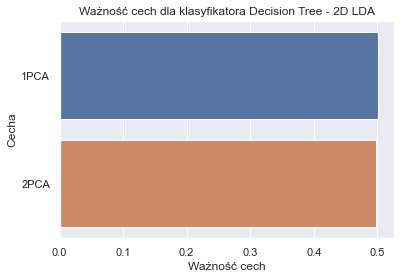

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.6516666666666666
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.6619047619047619
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.671904761904762
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.6466666666666667


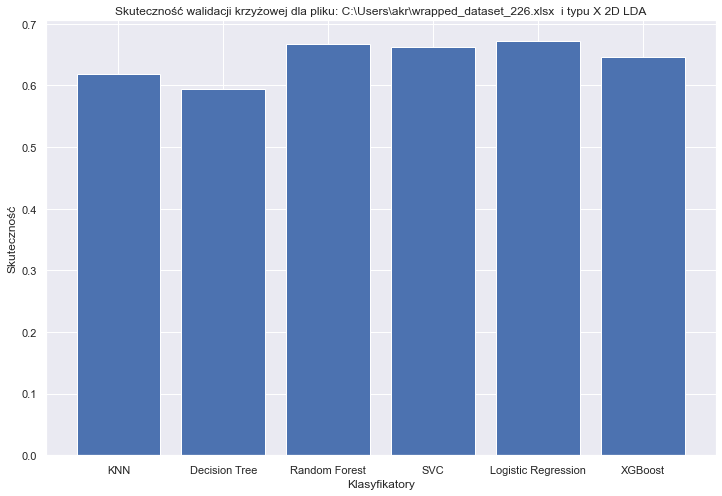

--------------

KLASYFIKACJA DLA ZBIORU DANYCH: C:\Users\akr\wrapped_dataset_20s_226.xlsx

Próba dla 26D

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.5302380952380952
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.37738095238095243


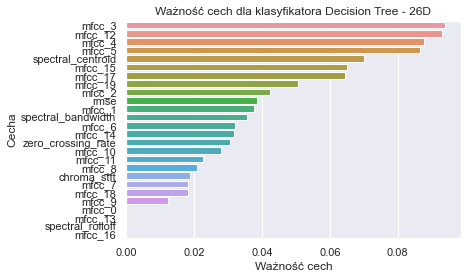

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.5680952380952381
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.47619047619047616
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.5197619047619048
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.534047619047619


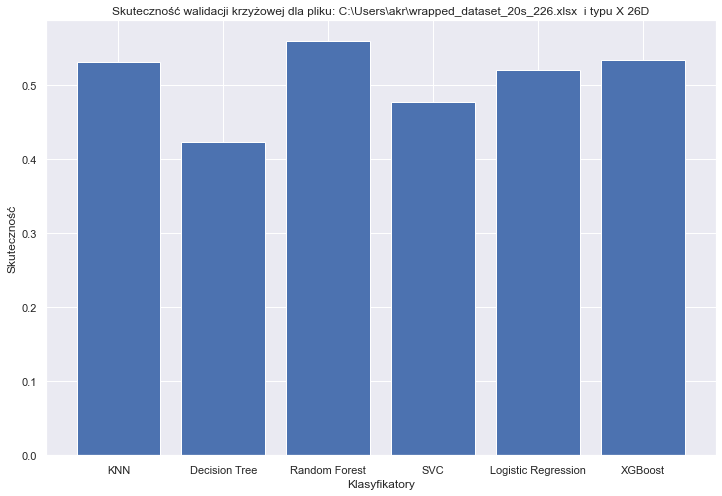

--------------

Próba dla 2D LDA

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.5307142857142856
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.495


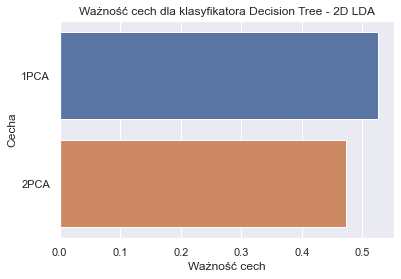

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.5397619047619047
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.6333333333333333
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.633095238095238
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.4859523809523809


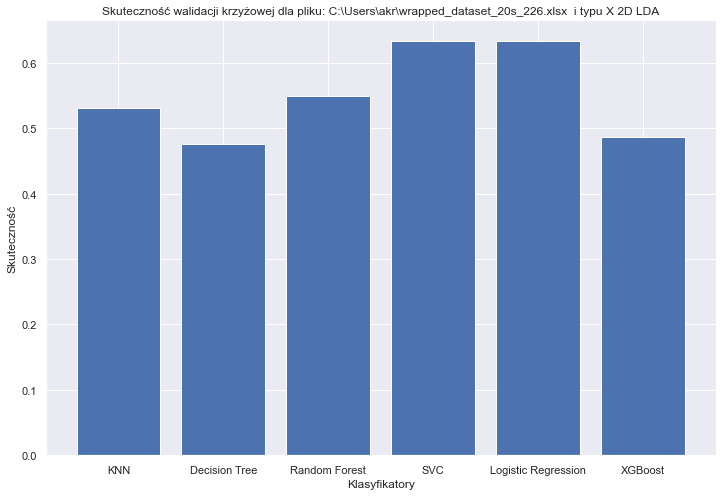

--------------

KLASYFIKACJA DLA ZBIORU DANYCH: C:\Users\akr\wrapped_dataset_vocal_226.xlsx

Próba dla 26D

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.6328571428571428
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.46952380952380957


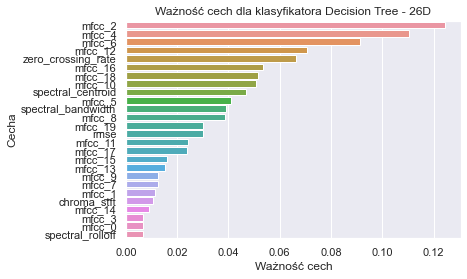

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.6916666666666667
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.6376190476190475
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.7004761904761904
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.6726190476190477


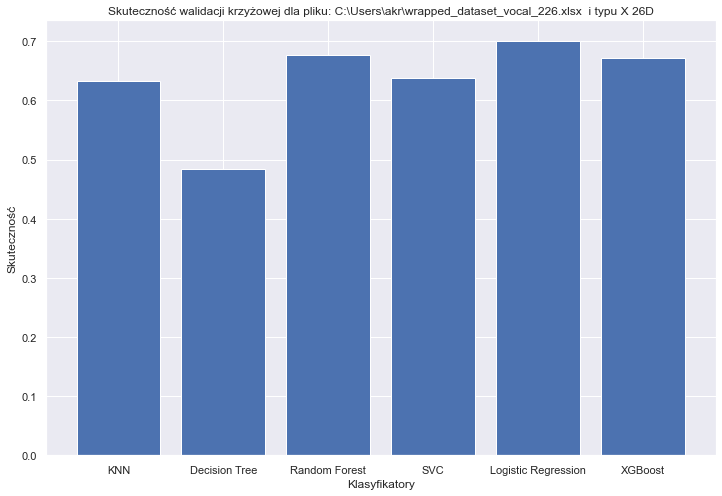

--------------

Próba dla 2D LDA

Wynik dla klasyfikatora KNN usredniony 10 prób krzyżowych: 0.6614285714285715
Wynik dla klasyfikatora Decision Tree usredniony 10 prób krzyżowych: 0.6754761904761903


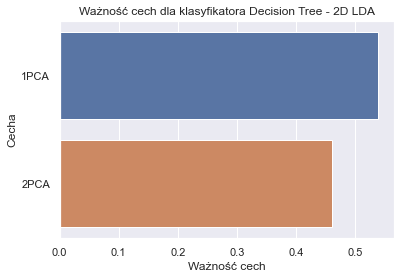

Wynik dla klasyfikatora Random Forest usredniony 10 prób krzyżowych: 0.7004761904761905
Wynik dla klasyfikatora SVC usredniony 10 prób krzyżowych: 0.7195238095238096
Wynik dla klasyfikatora Logistic Regression usredniony 10 prób krzyżowych: 0.7252380952380952
Wynik dla klasyfikatora XGBoost usredniony 10 prób krzyżowych: 0.675


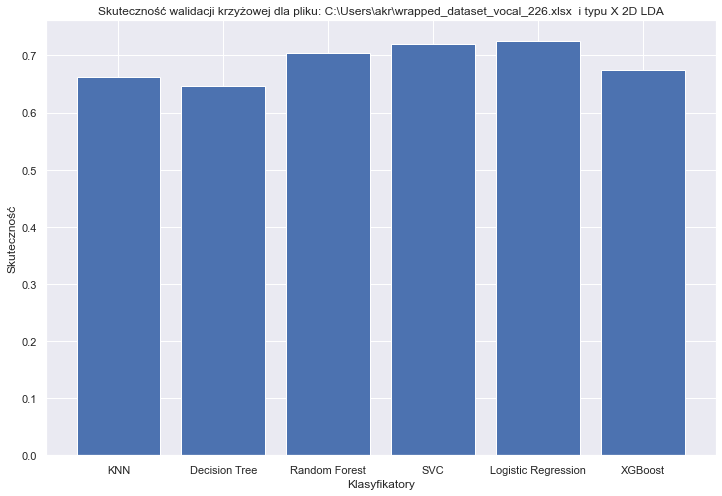

--------------



In [7]:
for plik in pliki_danych:
    print(f'KLASYFIKACJA DLA ZBIORU DANYCH: {plik}\n')
    df = pd.read_excel(plik)

    # zamiana etykiet z kolaboracjami na spojne
    df['artist'] = df['artist'].replace(['Coals, Bobkovski'], 'Coals')
    df['artist'] = df['artist'].replace(['Coals, Żabson'], 'Coals')
    df['artist'] = df['artist'].replace(['Coals, felicita'], 'Coals')
    artist_list = df['artist']

    # zmapowanie etykiet tekstowych na numeryczne
    encoder = LabelEncoder()
    encoder.fit(artist_list)
    le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    y = encoder.fit_transform(artist_list)

    # standaryzacja danych wejsciowych
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(df[lista_atryburow], dtype=float))

    # przygotowanie zredukowanego algorytmem LDA wektora chech X
    lda2d = LDA(n_components=2)
    X_r2 = lda2d.fit(X, y).transform(X)
    df2 = pd.DataFrame(X_r2)
    df2['album'] = y
    lda2d_x = df2[[0, 1]]
    lda2d_y = df2['album']

    # podzielenie zbiorów na testowe i treningowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(lda2d_x, lda2d_y, test_size=0.1)

    X_train_vect = [X_train, X_train_lda]
    X_test_vect = [X_test, X_test_lda]
    y_train_vect = [y_train, y_train_lda]
    y_test_vect = [y_test, y_test_lda]

    typy_x = ['26D', '2D LDA']

    for k in range(len(X_train_vect)):
        print(f"Próba dla {typy_x[k]}\n")
        for i in range(len(klasyfikatory)):
            klasyfikator = klasyfikatory[i]
            klasyfikator.fit(X_train_vect[k], y_train_vect[k])
            y_pred_test = klasyfikator.predict(X_test_vect[k])
            scores = cross_val_score(klasyfikator, X_train_vect[k], y_train_vect[k], cv=10)
            print(f'Wynik dla klasyfikatora {klasyfikatory_names[i]} usredniony 10 prób krzyżowych: {np.mean(scores)}')

            if isinstance(klasyfikator, DecisionTreeClassifier):
                # Wyświetlenie ważności cech
                feature_importance = klasyfikator.feature_importances_
                sorted_indices = np.argsort(feature_importance)[::-1]
                sorted_features = [lista_atryburow[i] for i in sorted_indices]

                # Zmiana etykiet dla zredukowanej macierzy dwuwymiarowej
                if k == 1:
                    sorted_features[0] = '1PCA'
                    sorted_features[1] = '2PCA'

                sns.barplot(x=feature_importance[sorted_indices], y=sorted_features)
                plt.title(f'Ważność cech dla klasyfikatora Decision Tree - {typy_x[k]}')
                plt.xlabel('Ważność cech')
                plt.ylabel('Cecha')
                plt.show()

        # Wykresy słupkowe skuteczności walidacji krzyżowej
        plt.figure(figsize=(12, 8))
        plt.bar(klasyfikatory_names, [np.mean(cross_val_score(klasyfikator, X_train_vect[k], y_train_vect[k], cv=10))
                                      for klasyfikator in klasyfikatory])
        plt.title(f'Skuteczność walidacji krzyżowej dla pliku: {plik}  i typu X {typy_x[k]}')
        plt.xlabel('Klasyfikatory')
        plt.ylabel('Skuteczność')
        plt.show()
        print("--------------\n")
